In [14]:
import pandas as pd
df = pd.read_csv('preprocessed_data.csv')

In [15]:
df = df.rename(columns={'Unnamed: 0': 'datetime'})

In [16]:
df.columns

Index(['datetime', 'datetime', 'average_temperature_C',
       'total_net_AC_voltage_V', 'total_time_run_total_h',
       'total_todays_energy_kWh', 'total_Export Energy',
       'total_last_active_fault', 'total_yesterdays_energy_kWh',
       'average_average_cosphii_percent', 'total_Accumulated Export Energy',
       'total_output_current_A', 'total_output_power_kW',
       'total_time_run_today_h', 'total_time_run_yesterday_h',
       'total_energy_counter_MWh', 'total_DC_voltage_DCV',
       'total_net_frequency_Hz', 'total_grid_connections',
       'WMS 01 ambient_temperature', 'WMS 01 irradiance', 'WMS 01 wind_speed',
       'hour'],
      dtype='object')

In [9]:
df['total_output_power_kW'].describe()

count    8784.000000
mean      708.865998
std       990.752002
min         0.000000
25%         0.000000
50%         6.000000
75%      1300.000000
max      3901.000000
Name: total_output_power_kW, dtype: float64

In [16]:
int(len(df) * 0.8)


7027

In [18]:
df = df[:7027]

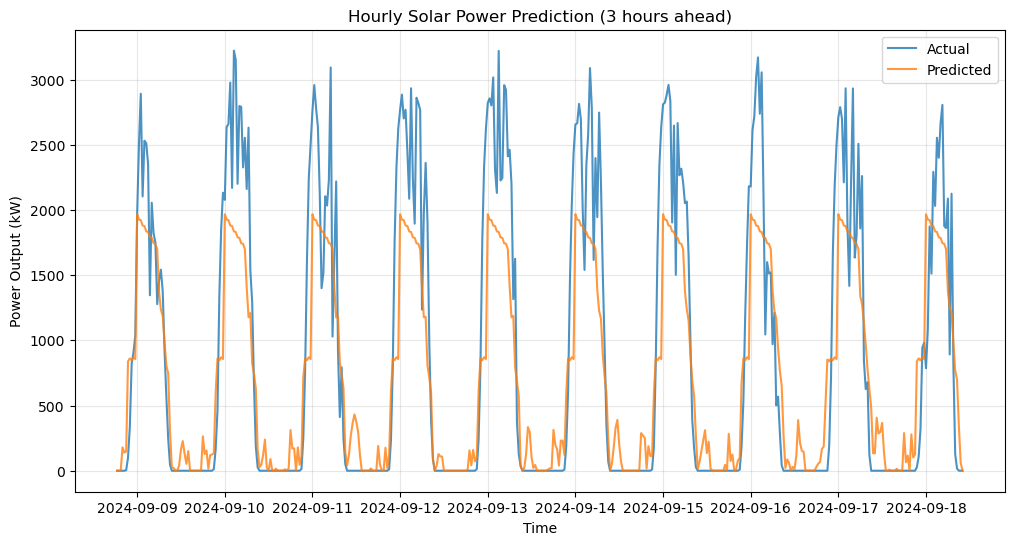

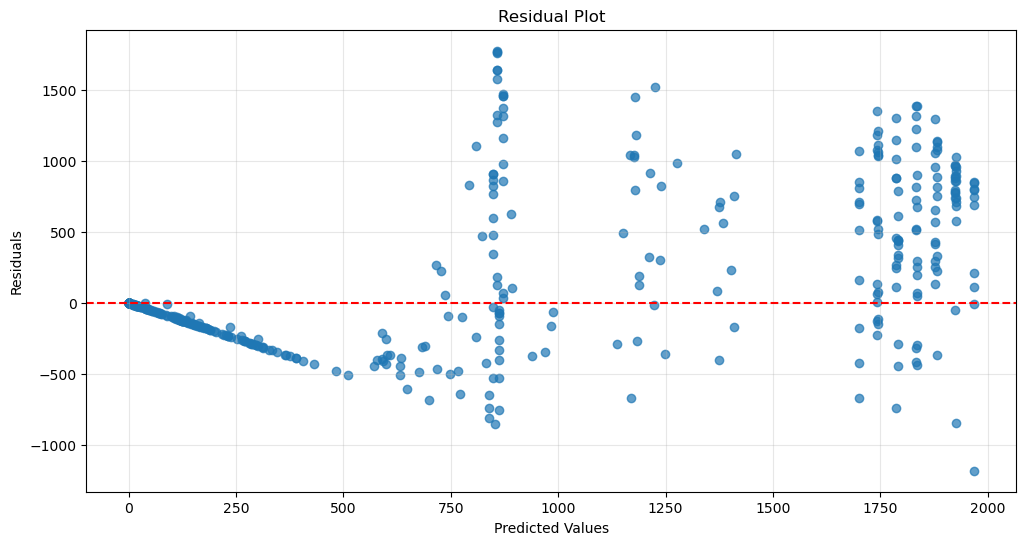

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class HourlyForecastModel:
    def __init__(self, data=None, file_path=None):
        """
        Initialize the model with either a DataFrame or a CSV file path.

        Parameters:
        - data: pandas DataFrame containing the input data.
        - file_path: path to the CSV file containing the data.
        """
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Either a DataFrame or a file path must be provided.")

        self.model = LinearRegression()
        self.scaler = MinMaxScaler()
        self.features = [
            'power_lag_1', 'power_lag_3', 'power_lag_6', 
            'temp_lag_1', 'temp_lag_3', 'temp_lag_6', 
            'power_ma_3', 'power_ma_6', 'temp_ma_3', 
            'WMS 01 irradiance', 'hour', 'hours_since_sunrise', 'hours_until_sunset', 'is_daytime'
        ]

    def preprocess_data(self):
        """Preprocess the dataset to create time-based features and lag variables."""
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        self.df['hour'] = self.df.index.hour
        self.df['minute'] = self.df.index.minute

        # Time since sunrise (assumed 6 AM)
        self.df['hours_since_sunrise'] = self.df['hour'] + self.df['minute'] / 60 - 6
        self.df['hours_since_sunrise'] = self.df['hours_since_sunrise'].apply(lambda x: max(0, x))

        # Time until sunset (assumed 8 PM)
        self.df['hours_until_sunset'] = 18 - (self.df['hour'] + self.df['minute'] / 60)
        self.df['hours_until_sunset'] = self.df['hours_until_sunset'].apply(lambda x: max(0, x))

        # Is daytime (06:00-18:00)
        self.df['is_daytime'] = ((self.df['hour'] >= 6) & (self.df['hour'] < 18)).astype(int)

        # Aggregate data by hour
        df_hourly = self.df.resample('30T').mean()

        # Rolling features
        df_hourly['power_ma_3'] = df_hourly['total_output_power_kW'].rolling(window=3).mean()
        df_hourly['power_ma_6'] = df_hourly['total_output_power_kW'].rolling(window=6).mean()
        df_hourly['temp_ma_3'] = df_hourly['average_temperature_C'].rolling(window=3).mean()

        # Lag features
        for lag in [1, 3, 6]:
            df_hourly[f'power_lag_{lag}'] = df_hourly['total_output_power_kW'].shift(lag)
            df_hourly[f'temp_lag_{lag}'] = df_hourly['average_temperature_C'].shift(lag)

        # Target variable (predict power 3 hours ahead)
        df_hourly['power_future'] = df_hourly['total_output_power_kW'].shift(-18)

        # Drop NaN values
        self.df_clean = df_hourly.dropna()

    def train_model(self):
        """Train the linear regression model."""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Train-test split (80% train, 20% test)
        split_idx = int(len(X) * 0.8)
        self.X_train, self.X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        self.y_train, self.y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Train the model
        self.model.fit(self.X_train_scaled, self.y_train)

    def evaluate_model(self):
        """Evaluate the model and return performance metrics."""
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)  # clip to zero to get non-negative predictions

        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }

        # Feature importance
        importance = pd.DataFrame({
            'Feature': self.features,
            'Importance': np.abs(self.model.coef_)
        }).sort_values('Importance', ascending=False)

        self.metrics['feature_importance'] = importance
        return self.metrics

    def plot_results(self):
        """Plot actual vs predicted power output and residuals."""
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.index, self.y_test.values, label='Actual', alpha=0.8)
        plt.plot(self.y_test.index, y_pred, label='Predicted', alpha=0.8)
        plt.title('Hourly Solar Power Prediction (3 hours ahead)')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Residual plot
        residuals = self.y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residual Plot')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True, alpha=0.3)
        plt.show()

    def run_pipeline(self):
        """Run the full pipeline: preprocessing, training, evaluating, and plotting."""
        self.preprocess_data()
        self.train_model()
        results = self.evaluate_model()
        self.plot_results()
        return results


# If using a CSV file:
# model = HourlyForecastModel(file_path='preprocessed_data.csv')
# If using a pandas DataFrame:
model = HourlyForecastModel(data=df)

results = model.run_pipeline()

In [22]:
results

{'rmse': 547.8114832809758,
 'mae': 363.2869918193125,
 'r2': 0.7544534582249385,
 'feature_importance':                 Feature   Importance
 12   hours_until_sunset  1465.866953
 5            temp_lag_6  1231.003396
 7            power_ma_6   965.718961
 2           power_lag_6   877.626776
 10                 hour   846.235036
 8             temp_ma_3   698.009993
 6            power_ma_3   647.657480
 3            temp_lag_1   641.435225
 4            temp_lag_3   626.553874
 9     WMS 01 irradiance   580.668669
 11  hours_since_sunrise   491.535294
 13           is_daytime   380.082505
 0           power_lag_1   158.173876
 1           power_lag_3    99.810275}